In [82]:

# Kode fra Magnus


import sqlite3
import requests
import secrets
from collections import Counter, OrderedDict
import pandas as pd
import os
from dhlab import nbtext as nb
from flask import g, Flask, request, render_template, json, session, Response, abort
import io
import base64
import re
import time
import random
import html
import json
import datetime
import dhlab.nbtext as nb
import dhlab.module_update as mu
from bs4 import BeautifulSoup

class ReverseProxied(object):

    def __init__(self, app, script_name=None, scheme=None, server=None):
        self.app = app
        self.script_name = script_name
        self.scheme = scheme
        self.server = server

    def __call__(self, environ, start_response):
        script_name = environ.get('HTTP_X_SCRIPT_NAME', '') or self.script_name
        if script_name:
            environ['SCRIPT_NAME'] = script_name
            path_info = environ['PATH_INFO']
            if path_info.startswith(script_name):
                environ['PATH_INFO'] = path_info[len(script_name):]
        scheme = environ.get('HTTP_X_SCHEME', '') or self.scheme
        if scheme:
            environ['wsgi.url_scheme'] = scheme
        server = environ.get('HTTP_X_FORWARDED_SERVER', '') or self.server
        if server:
            environ['HTTP_HOST'] = server
        return self.app(environ, start_response)



## HELPER FUNCTIONS

def highlight(string, matchObject, tag='span', html_class='highlight'):
    span = matchObject.span()
    return '{}<{} class="{}">{}</{}>{}'.format(string[0:span[0]], tag, html_class, string[span[0]:span[1]], tag, string[span[1]:])

def query_string_factory(keywords, collocate):
    import urllib.parse
    pairs = ['("{} {}"~10)'.format(keyword, collocate) for keyword in keywords]
    queryString = ' | '.join(pairs)
    return urllib.parse.quote(queryString)

def group_frames(df, bins=10):
    agg = pd.DataFrame()
    step = bins
    for i in range(0, len(df.columns), step):
        agg[df.columns[i]] = df[df.columns[i:i+step]].sum(axis=1)
    return agg

def get_reference_frequencies(pathToDb, words=(), period=(1950, 2010)):
    with sqlite3.connect(pathToDb) as con:
        cur = con.cursor()

        # create a temp table, insert words
        cur.execute("CREATE TEMP TABLE words (word varchar);")

        for word in words:
            cur.execute("INSERT INTO words VALUES(?)", (word,))

        # create index
        cur.execute("CREATE INDEX _ww_ ON words(word);")

        # join the two tables forcing new index
        reference = pd.read_sql("SELECT year, u.word, freq FROM unigram u INNER JOIN words w INDEXED BY _ww_ ON w.word = u.word WHERE year BETWEEN ? and ?;", con, params=period)

        return reference






def query_db_dict(query, args=(), one=False):
    """ Return results as dictionary """

    cur = g.db.execute(query, args)
    rv = [OrderedDict((cur.description[idx][0], value)
               for idx, value in enumerate(row)) for row in cur.fetchall()]
    return (rv[0] if rv else None) if one else rv

def query_db_row(query, args=(), one=False):
    """ Return results as rows """

    cur = g.db.execute(query, args)
    rv = [list((value)
                for idx, value in enumerate(row)) for row in cur.fetchall()]
    return (rv[0] if rv else None) if one else rv

## ROUTES

## LATIN CORPUS


def render_latin():
    return render_template('ext/latin.html')


def render_latin_editor():
    return render_template('ext/latin_editor.html')

def render_search_tips():
    return render_template('ext/searchtips.html')


def render_about():
    return render_template('ext/about.html')


def word():
    pd.set_option('display.max_colwidth', -1)

    param = {'query': request.args.get('q'), 'size': request.args.get('size'), 'window': request.args.get('window')}

    r = requests.get('https://api.nb.no/korpus/latin', params=param)

    res = ''
    if r.status_code == 200:
        res += r.text

    r = requests.get('https://api.nb.no/korpus/latin_conc', params=param)
    if r.status_code == 200:
        res += r.text

    if res == '':
        res += "<p>Ingen treff</p>"

    soup = BeautifulSoup(res, 'html.parser')

    rows = []

    for idx,item in enumerate(soup.find_all('div')):
        rows.append([str(item.find_next('a')),  str(item.find_next('sitat'))])

    concTable = pd.DataFrame(rows, columns=['Reference', 'Concordance'])

    concTableHtml = concTable.to_html(escape=False, index=False,border=0,classes='display')

    concTableHtml += """<script>$(document).ready( function () {
                $('.dataframe').DataTable();
            } );</script>"""

    return concTableHtml


def word_editor():
    pd.set_option('display.max_colwidth', -1)

    param = {'query': request.args.get('q'), 'size': request.args.get('size'), 'window': request.args.get('window')}

    r = requests.get('https://api.nb.no/korpus/latin', params=param)

    res = ''
    if r.status_code == 200:
        res += r.text

    r = requests.get('https://api.nb.no/korpus/latin_conc', params=param)
    if r.status_code == 200:
        res += r.text

    if res == '':
        res += "<p>Ingen treff</p>"

    soup = BeautifulSoup(res, 'html.parser')

    rows = []

    for idx,item in enumerate(soup.find_all('div')):
        snippet = html.escape(str(item.find_next('sitatledd')))
        rows.append([str(item.find_next('a')),  str(item.find_next('sitat')), """<input style="display:none;" type="text" value="%s" id="textid-%s"><button onclick="copyFunction('textid-%s')">Export</button>""" % (snippet,idx,idx)])

    concTable = pd.DataFrame(rows, columns=['Reference', 'Concordance', 'Export'])

    concTableHtml = concTable.to_html(escape=False, index=False,border=0,classes='display')

    concTableHtml += """<script>$(document).ready( function () {
                $('.dataframe').DataTable();
            } );</script>"""

    return concTableHtml

## CORPUSBUILDER


def index():
    return render_template('index.html')


def nbsearch():
    query = request.args.get('query', '')
    r = requests.get('https://api.nb.no/ngram/urn', json={'freetext': query, 'limit':1000})
    results = r.json()
    results = pd.DataFrame(results, columns=["URN", "Forfatter", "Tittel", "År"])
    # ensure that year is not a float
    #results = results.astype({'År': 'Int64'})
    return render_template('nbsearch-results.html', results=results)


def cart():
    return render_template('cart.html')


def analysis():
    return render_template('analysis.html')


def conc():
    if request.method == 'POST':
        # process urns
        data = request.get_json()
        urns = nb.pure_urn(data['urns'])
        query = data['query']
        para = {'word':query, 'urns': urns, 'size': 50}
        jsonConc = requests.post('https://api.nb.no/ngram/urnkonk', json = para).json()
        return render_template('concresults.html', results=jsonConc)
    else:
        return render_template('conc.html')



def coll_context():
    data = request.get_json()
    collWord = data['collWord']
    rows = []

    if data['corpus'] == "newspapers":
        corpus = 'aviser'
    else:
        corpus = 'bøker'
        urns = data['urns']

    wordforms = data['query'].split('+')

    for wordform in wordforms:

        if corpus == 'aviser':
            collConc = nb.concordance(wordform, yearfrom=data['yearfrom'], yearto=data['yearto'], corpus = corpus, size=1000, kind='json', before=10, after=10)
        else:
            para = {'word':wordform, 'urns': urns, 'size': 1000, 'before': 10, 'after': 10}
            collConc = requests.post('https://api.nb.no/ngram/urnkonk', json = para).json()

        searchStr = re.compile(r'\b{}\b'.format(collWord), flags=re.IGNORECASE)

        for result in collConc:
            # get matches
            if result['before']:
                before_match = re.search(searchStr, result['before'])
            else:
                before_match = ''

            if result['after']:
                after_match = re.search(searchStr, result['after'])
            else:
                after_match = ''

            # if there are matches
            if before_match or after_match:
                # highlight match
                if before_match:
                    result['before'] = highlight(result['before'], before_match)
                if after_match:
                    result['after'] = highlight(result['after'], after_match)

                url = result['urn'] + '?searchText=' + collWord
                urn = result['urn']

                rows.append([url, urn, result['before'], result['word'], result['after']])

    return render_template('coll_context.html', rows=rows)

## Experimental


## NBDIGITAL Elastic

def create_frame_from_bucket(bucket, agg_levels=["year", "month", "day"]):
    rows=[]

    for year in bucket:
        if 'month' in agg_levels and 'buckets' in year["aggregations"][0]:
            for month in year["aggregations"][0]["buckets"]:
                if 'day' in agg_levels and 'buckets' in month['aggregations'][0]:
                    for day in month['aggregations'][0]['buckets']:
                        rows.append([year['key'], month['key'], day['key'], day['count']])
                else:
                    rows.append([year['key'], month['key'], '01', month['count']])
        else:
            rows.append([year['key'], '01','01',year['count']])

    df = pd.DataFrame(rows)
    df.columns = ['year','month','day','count']
    for level in ['year', 'month', 'day']:
        df[level] = pd.to_numeric(df[level])
    df = df[['year', 'month','day', 'count']]
    df["timestamp"] = pd.to_datetime(df[['year','month','day']])
    df = df[["timestamp", "count"]]
    df = df.set_index('timestamp')

    return df

def frame_to_c3_columns(frame):
    """ Converts a Pandas frame to the array based representation required by C3"""
    cols = []

    # x axis = index of data frame
    array = list(frame.index.to_native_types())
    array.insert(0, "x")
    cols.append(array)

    # loop cols
    for col in frame.columns:
        array = list(frame[col])
        array.insert(0, col)
        cols.append(array)

    return cols

def smooth_column(column, smooth_factor=3):
    """ Implements rolling average similar to Google Ngrams and NB N-gram """

    result = list()
    values = list(column)
    for idx,value in enumerate(values):
        window = values[max(0, idx - smooth_factor):idx+smooth_factor+1]
        avg = sum(window) / len(window)
        result.append(avg)
    return result

def return_terms(terms, maxChar=200, maxTerms=10, maxWildcards=5):
    """Gets a string of terms and returns them as a list, with some clean-up"""
    terms_array = []
    # index for wildcards (not allowed to exceed maxWildcards, these ones are powerful)
    wildcardIdx = 0
    # we only allow a certain amount of characters in the terms string
    terms = terms[:maxChar]
    # removes unnecessary whitespace or empty query terms
    terms = re.sub(r',\s{0,},',',', terms)
    # splits on comma (with following whitespace): commas may be masked by quoatation marks
    terms = re.findall('[^\,\"]+|\"[^"]*\"', terms)
    # gets number of terms
    nTerms = len(terms)
    # checks if number exceeds maxTerms, remaining ones are removed
    if nTerms >= maxTerms:
        terms = terms[:maxTerms]
        nTerms = maxTerms
    # loops through each term
    for i in range(nTerms):
        # removes illegal wildcards (according to maxWildcards)
        if "*" in terms[i] and wildcardIdx < maxWildcards:
            wildcardIdx += 1
        else:
            terms[i] = terms[i].replace("*", "")
        # removes whitespace at the beginning or the end of the string
        terms[i] = re.sub(r'^\s+', '', terms[i])
        terms[i] = re.sub(r'\s+$', '', terms[i])
        # removes mask for comma
        if terms[i] == '","':
            terms[i] = re.sub(r'","',',', terms[i])
        # removes whitespace between '+' and terms
        if "+" in terms[i]:
            terms[i] = re.sub(r'\s+\+', '+', terms[i])
            terms[i] = re.sub(r'\+\s+', '+', terms[i])

    # create array
    for i in range(nTerms):
        if "+" in terms[i]:
            multiple = terms[i].split("+")
            terms_array.append(multiple)
        else:
            terms_array.append([terms[i]])

    return terms_array


def nbdigital_trends(terms = None, mediatype = 'bøker', datetime_from = '18000101', datetime_to = '20200101', smoothing_factor=1):

    delta_time = datetime.datetime.strptime(datetime_to, '%Y%m%d') - datetime.datetime.strptime(datetime_from, '%Y%m%d')

    # check
    if mediatype == "bøker":
        aggs = 'year:9999'
        agg_levels = ['year']
        timeFormat = "'%Y'"
    else:
        if delta_time.days < 3650:
            aggs = 'year:9999,month,day'
            agg_levels = ['year', 'month', 'day']
            timeFormat = "'%Y-%m-%d'"
        else:
            aggs = 'year:9999'
            agg_levels = ['year']
            timeFormat = "'%Y'"

    query = {
            'filter':['mediatype:%s' % mediatype, 'date:[%s TO %s]' % (datetime_from, datetime_to)],
            'aggs': [aggs]
        }

    # get total
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    totalFreq = create_frame_from_bucket(r.json()["_embedded"]["aggregations"][0]["buckets"], agg_levels=agg_levels)
    totalFreq = totalFreq.sort_index()

    termFrame = pd.DataFrame(index=totalFreq.index)

    # get docfreq for each term, aggregating word forms
    for term in terms:
        query['q'] = (' OR ').join(term)
        r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
        termFreq = create_frame_from_bucket(r.json()["_embedded"]["aggregations"][0]["buckets"], agg_levels=agg_levels)
        #relativeFreq = termFreq/totalFreq
        #relativeFreq.columns = ['/'.join(term)]
        termFreq.columns = ['/'.join(term)]
        termFrame = termFrame.merge(termFreq, left_index=True, right_index=True)

    # fill na
    termFrameSmoothed = termFrame.fillna(0)

    # smooth
    for column in termFrameSmoothed.columns:
        termFrameSmoothed[column] = smooth_column(termFrameSmoothed[column], smooth_factor=smoothing_factor)

   
    return termFrameSmoothed
    




In [81]:
mu.code_toggle()

In [83]:
fraser_ = """Skandinavisk(e) Union; skandinaviske Sympathier; skandinaviske Ide(e); skandinavisk(e) Forening; skandinavisk(e) Selskab; skandinaviske Sag; skandinaviske Norden; skandinavisk(e) Nationalitet(e); skandinavisk(e) Literatur; skandinavisk(e) Forbundsstat;
 
Skandinavisk* race; Skandinavisk* rase; Nordisk* race; Nordisk* rase; nordisk(e) forening; nordisk(e) Selskab; nordisk(e) Enhed/Enhet; nordisk(e) Nationalitet(e); nordisk(e) Literatur; nordisk(e) Forbundsstat; nordisk(e) Aand;nordiske(e) Folkeånd;nordisk(e) Folkeaand; nordisk(e) Kraft"""

In [84]:
fraser = [x.strip().replace('(e)', '*') for x in fraser_.split(';')]
fraser

['Skandinavisk* Union',
 'skandinaviske Sympathier',
 'skandinaviske Ide*',
 'skandinavisk* Forening',
 'skandinavisk* Selskab',
 'skandinaviske Sag',
 'skandinaviske Norden',
 'skandinavisk* Nationalitet*',
 'skandinavisk* Literatur',
 'skandinavisk* Forbundsstat',
 'Skandinavisk* race',
 'Skandinavisk* rase',
 'Nordisk* race',
 'Nordisk* rase',
 'nordisk* forening',
 'nordisk* Selskab',
 'nordisk* Enhed/Enhet',
 'nordisk* Nationalitet*',
 'nordisk* Literatur',
 'nordisk* Forbundsstat',
 'nordisk* Aand',
 'nordiske* Folkeånd',
 'nordisk* Folkeaand',
 'nordisk* Kraft']

In [85]:
from matplotlib import rcParams
rcParams['figure.max_open_warning'] = 50
import matplotlib.pyplot as plt


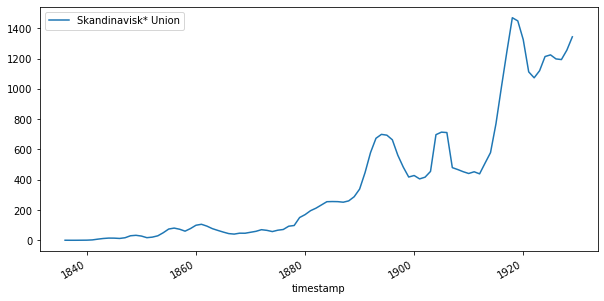

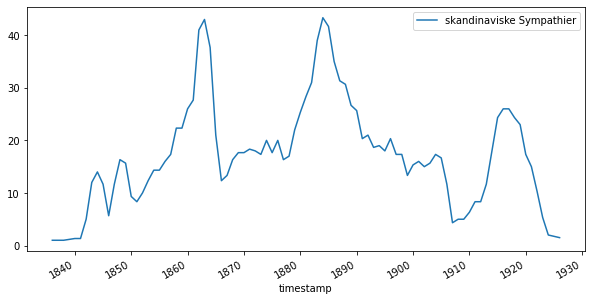

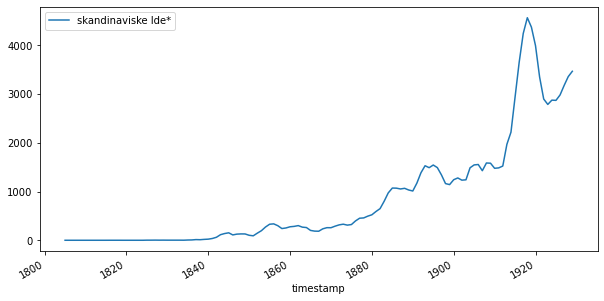

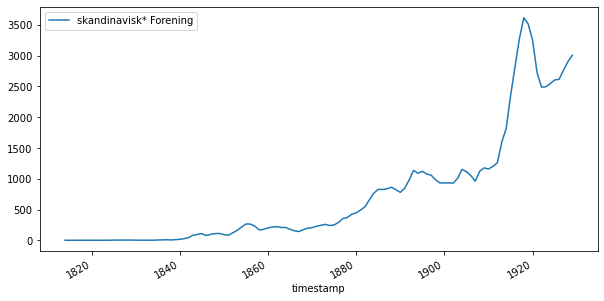

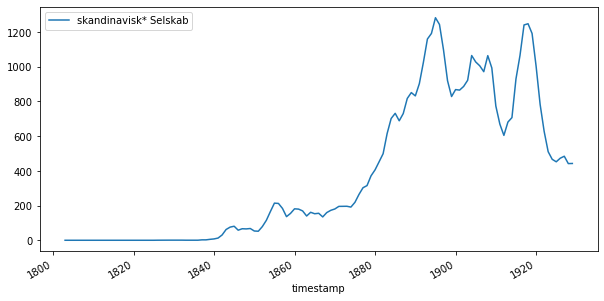

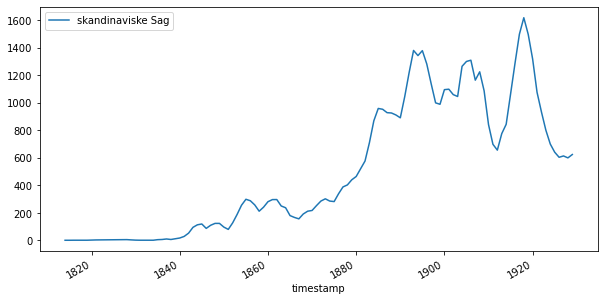

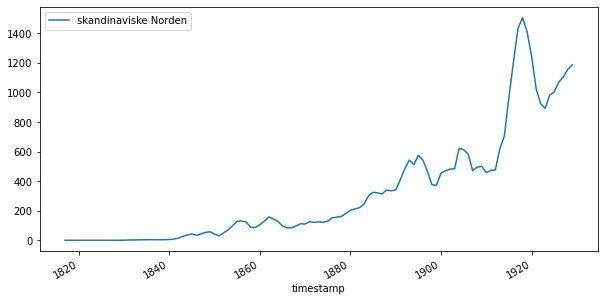

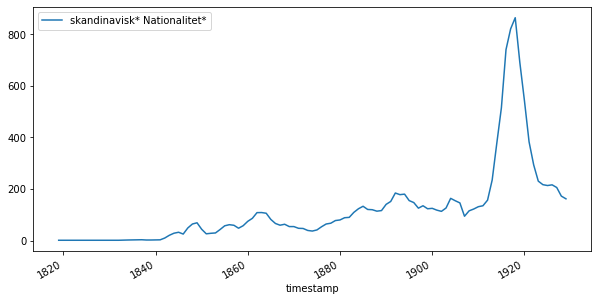

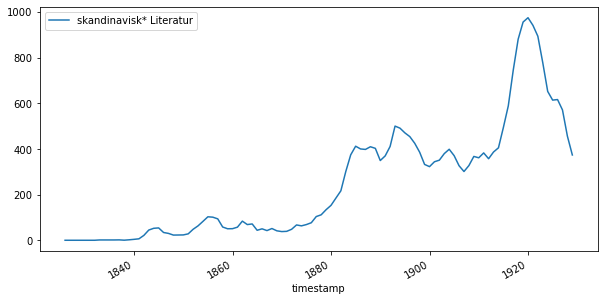

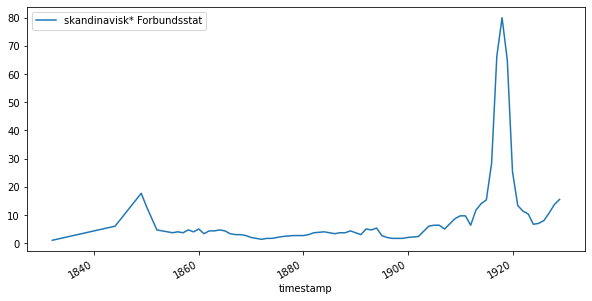

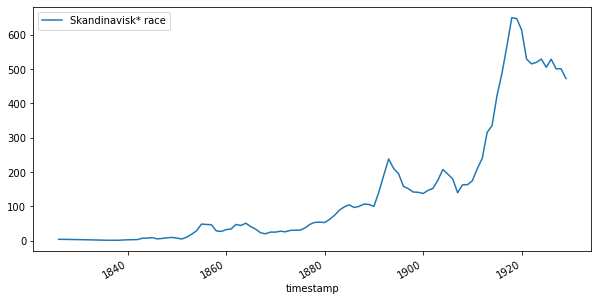

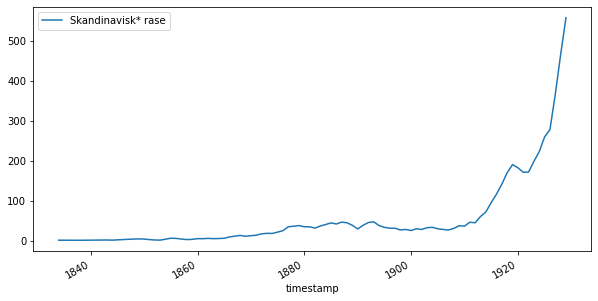

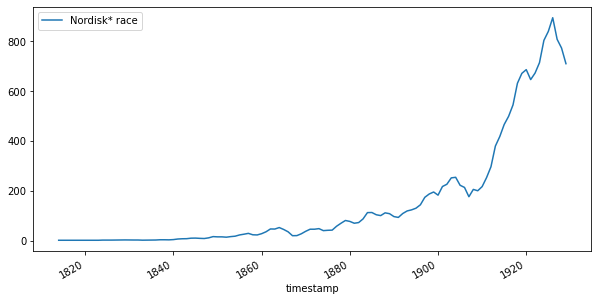

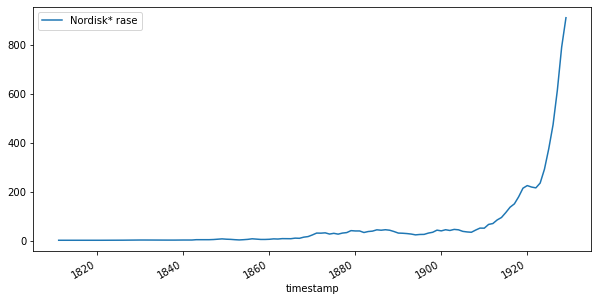

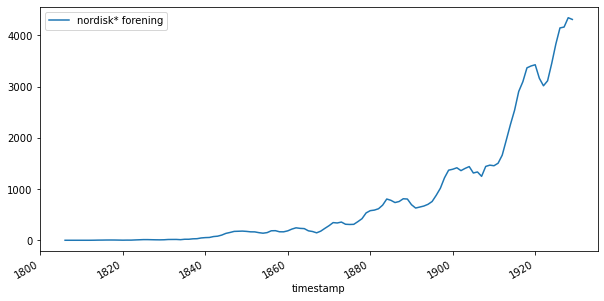

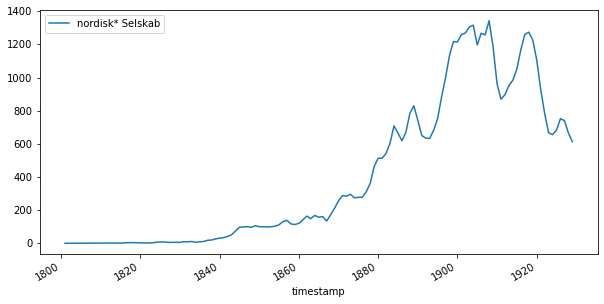

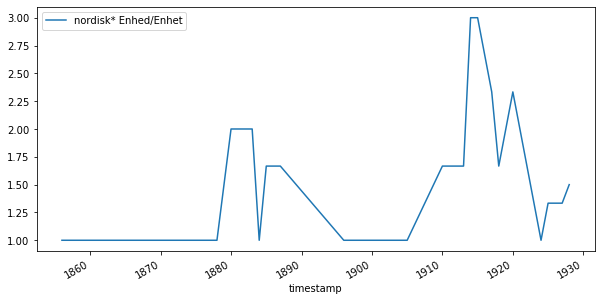

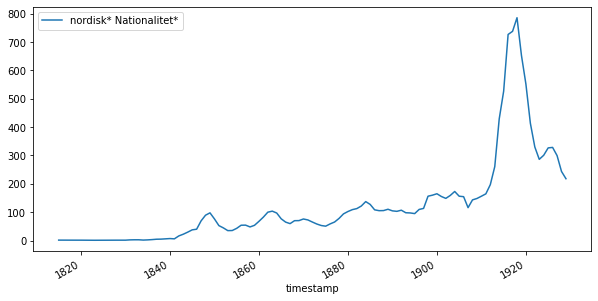

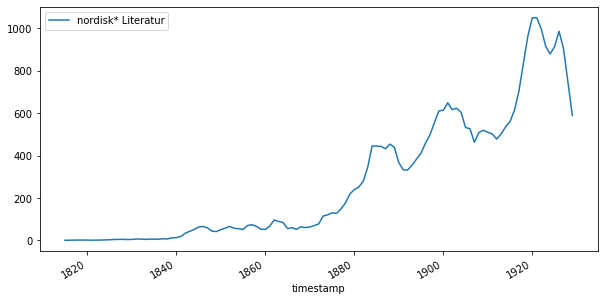

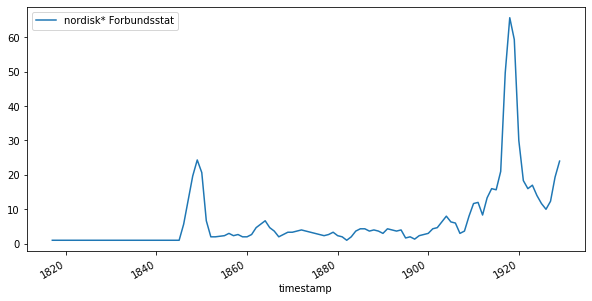

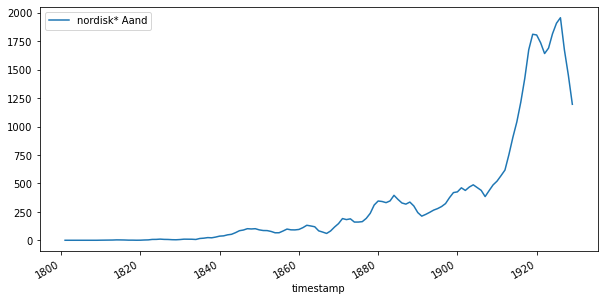

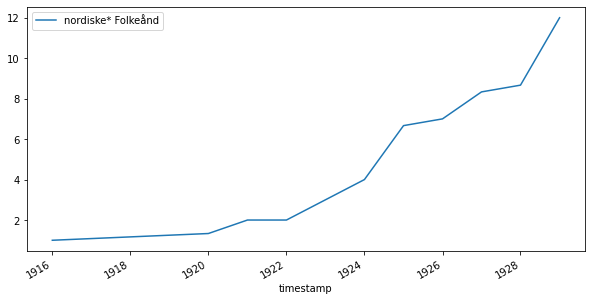

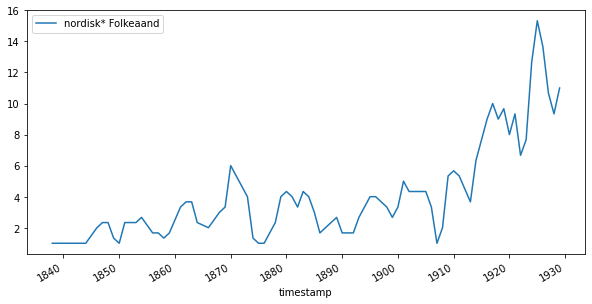

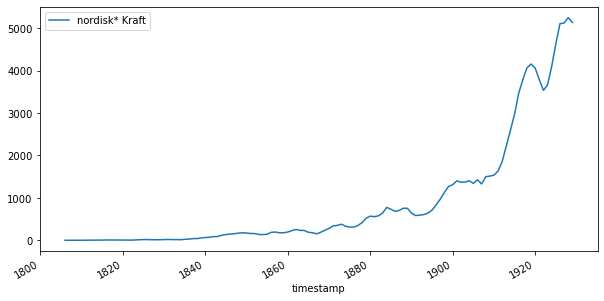

In [86]:
for x in fraser:
    try:
        nbdigital_trends(terms=[[x]],mediatype='aviser', datetime_from='18000101', datetime_to='19300101').plot(figsize = (10,5))
    except:
        print(x)


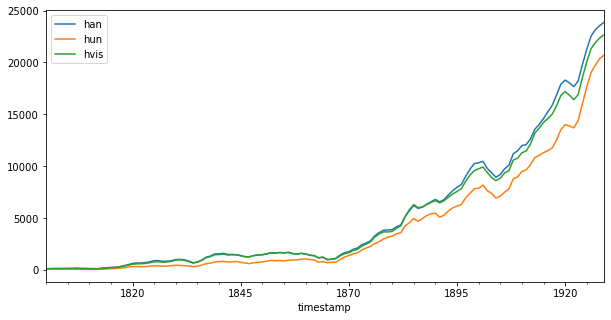

In [87]:
nbdigital_trends(terms=[['han'],['hun'],['hvis']],mediatype='aviser', datetime_from='18000101', datetime_to='19300101').plot(figsize = (10,5))

In [107]:
frasedict = {}
for x in fraser:
    parts = x.split()
    first = []
    second = []
    for y in ['', 'e', 'er']:
            first.append(parts[0].replace('*',y))
            second.append(parts[1].replace('*', y))
    result = list(set([f + ' ' + s for f in first for s in second]))
            
    frasedict[x] = result
frasedict

{'Skandinavisk* Union': ['Skandinaviske Union',
  'Skandinavisk Union',
  'Skandinavisker Union'],
 'skandinaviske Sympathier': ['skandinaviske Sympathier'],
 'skandinaviske Ide*': ['skandinaviske Ide',
  'skandinaviske Ideer',
  'skandinaviske Idee'],
 'skandinavisk* Forening': ['skandinavisk Forening',
  'skandinaviske Forening',
  'skandinavisker Forening'],
 'skandinavisk* Selskab': ['skandinavisker Selskab',
  'skandinaviske Selskab',
  'skandinavisk Selskab'],
 'skandinaviske Sag': ['skandinaviske Sag'],
 'skandinaviske Norden': ['skandinaviske Norden'],
 'skandinavisk* Nationalitet*': ['skandinavisk Nationalitete',
  'skandinavisk Nationalitet',
  'skandinaviske Nationalitete',
  'skandinavisker Nationalitet',
  'skandinavisk Nationaliteter',
  'skandinavisker Nationaliteter',
  'skandinaviske Nationaliteter',
  'skandinaviske Nationalitet',
  'skandinavisker Nationalitete'],
 'skandinavisk* Literatur': ['skandinaviske Literatur',
  'skandinavisker Literatur',
  'skandinavisk Li

In [257]:
bigrams = {
    z:pd.concat([
        nb.bigram(
            first = x.split()[0], 
            second=x.split()[1], 
            media = 'avis', 
            period=(1790, 1940)
        )
        for x in frasedict[z]
    ], 
        axis = 1
    ).sum(axis = 1)
    for z in frasedict 
}

In [258]:
alle_data = pd.concat([nb.frame(bigrams[x], x) for x in bigrams], axis = 1).fillna(0)

In [259]:
subset = alle_data[[x for x in alle_data if alle_data[x].sum() > 0]].sort_index()

In [260]:
alle_data.columns

Index(['Skandinavisk* Union', 'skandinaviske Sympathier', 'skandinaviske Ide*',
       'skandinavisk* Forening', 'skandinavisk* Selskab', 'skandinaviske Sag',
       'skandinaviske Norden', 'skandinavisk* Nationalitet*',
       'skandinavisk* Literatur', 'skandinavisk* Forbundsstat',
       'Skandinavisk* race', 'Skandinavisk* rase', 'Nordisk* race',
       'Nordisk* rase', 'nordisk* forening', 'nordisk* Selskab',
       'nordisk* Enhed/Enhet', 'nordisk* Nationalitet*', 'nordisk* Literatur',
       'nordisk* Forbundsstat', 'nordisk* Aand', 'nordiske* Folkeånd',
       'nordisk* Folkeaand', 'nordisk* Kraft'],
      dtype='object')

In [261]:
subset.columns

Index(['Skandinavisk* Union', 'skandinaviske Sympathier', 'skandinaviske Ide*',
       'skandinavisk* Forening', 'skandinavisk* Selskab', 'skandinaviske Sag',
       'skandinaviske Norden', 'skandinavisk* Nationalitet*',
       'skandinavisk* Literatur', 'skandinavisk* Forbundsstat',
       'Skandinavisk* race', 'Nordisk* rase', 'nordisk* forening',
       'nordisk* Selskab', 'nordisk* Nationalitet*', 'nordisk* Literatur',
       'nordisk* Forbundsstat', 'nordisk* Aand', 'nordisk* Folkeaand',
       'nordisk* Kraft'],
      dtype='object')

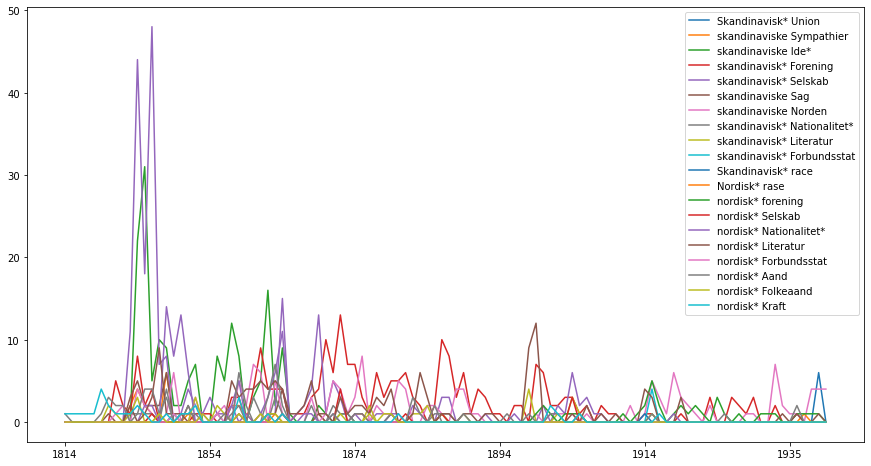

In [262]:
subset.plot(kind='line', figsize=(15,8));

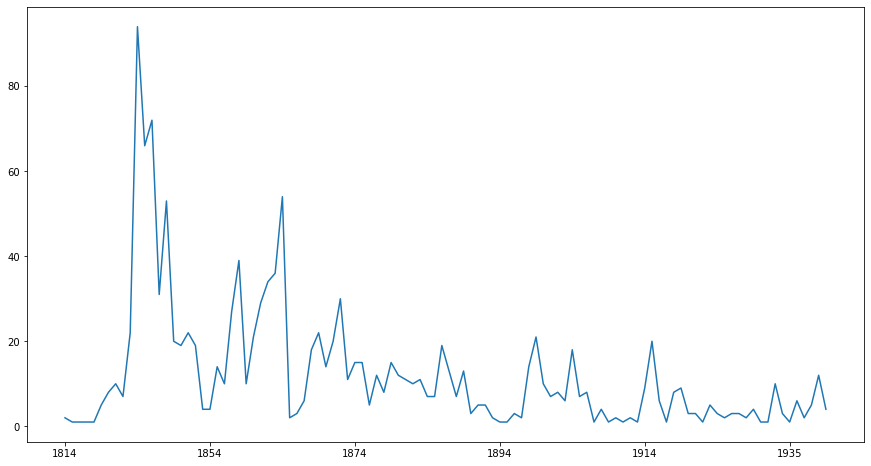

In [263]:
subset.sum(axis=1).plot(figsize=(15,8));

In [265]:
høyord = nb.frame(pd.concat([nb.unigram(x, period = (1790, 1940)) for x in "og . , i".split()], axis = 1).sum(axis = 1), 'ref')

In [266]:
høyord

,ref
1790,228321
1791,333160
1792,346687
1793,379574
1794,310246
...,...
1936,8132611
1937,9020901
1938,9304057
1939,9835459


In [267]:
høyord.loc[1814:1920].ref

1814     573640
1815     264418
1816     287595
1817     480178
1818     342509
         ...   
1916    5770300
1917    5912993
1918    6207187
1919    6048018
1920    6960629
Name: ref, Length: 107, dtype: int64

In [268]:
subset['ref'] = høyord.loc[1814:1920].ref

In [269]:
høyord.loc[1814]

ref    573640
Name: 1814, dtype: int64

In [270]:
subset.index = subset.index.astype('int64')

In [271]:
subset.loc[1814]

Skandinavisk* Union            0.0
skandinaviske Sympathier       0.0
skandinaviske Ide*             0.0
skandinavisk* Forening         0.0
skandinavisk* Selskab          0.0
skandinaviske Sag              0.0
skandinaviske Norden           0.0
skandinavisk* Nationalitet*    0.0
skandinavisk* Literatur        0.0
skandinavisk* Forbundsstat     0.0
Skandinavisk* race             0.0
Nordisk* rase                  0.0
nordisk* forening              0.0
nordisk* Selskab               0.0
nordisk* Nationalitet*         0.0
nordisk* Literatur             0.0
nordisk* Forbundsstat          0.0
nordisk* Aand                  1.0
nordisk* Folkeaand             0.0
nordisk* Kraft                 1.0
ref                            NaN
Name: 1814, dtype: float64

In [272]:
subset.ref = høyord.ref

In [273]:
subset

,Skandinavisk* Union,skandinaviske Sympathier,skandinaviske Ide*,skandinavisk* Forening,skandinavisk* Selskab,skandinaviske Sag,skandinaviske Norden,skandinavisk* Nationalitet*,skandinavisk* Literatur,skandinavisk* Forbundsstat,...,Nordisk* rase,nordisk* forening,nordisk* Selskab,nordisk* Nationalitet*,nordisk* Literatur,nordisk* Forbundsstat,nordisk* Aand,nordisk* Folkeaand,nordisk* Kraft,ref
1814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,573640
1815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,264418
1820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,324764
1831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,516682
1835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1090413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,8132611
1937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9020901
1938,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9304057
1939,6.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9835459


In [274]:
subsetrel = nb.frame({x:subset[x]/subset.ref for x in subset if x != 'ref'}).transpose().fillna(0)

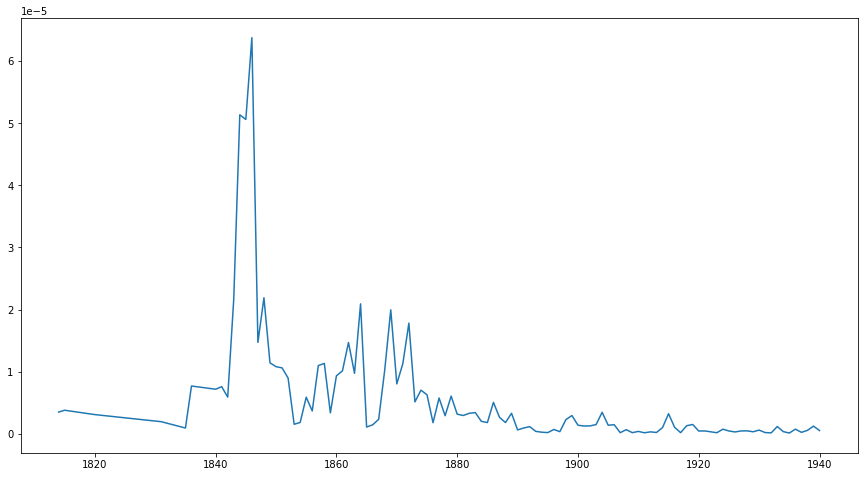

In [275]:
subsetrel.sum(axis=1).plot(figsize=(15,8))


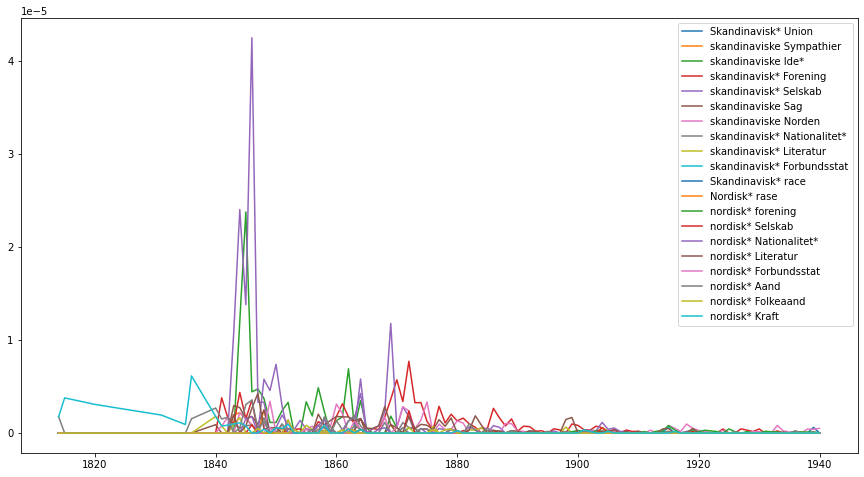

In [276]:
subsetrel.plot(figsize=(15,8))


In [277]:
from werkzeug.utils import secure_filename
import os

In [278]:
os.path.join('grafer', 'hall')

'grafer\\hall'

In [279]:
os.mkdir('grafer')

FileExistsError: [WinError 183] Kan ikke opprette en fil når filen allerede finnes: 'grafer'

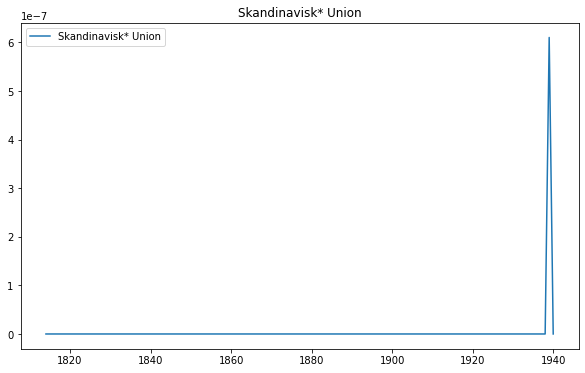

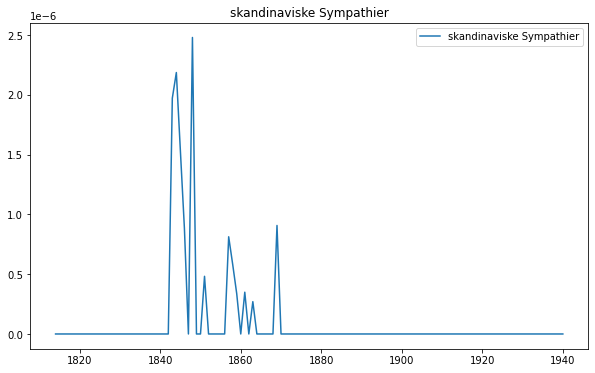

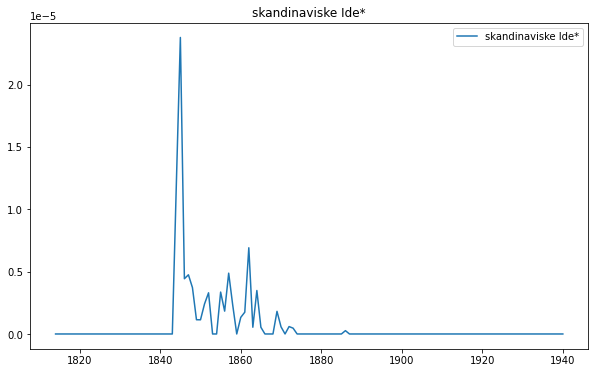

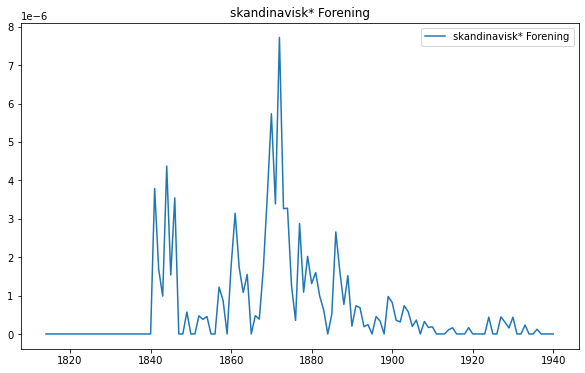

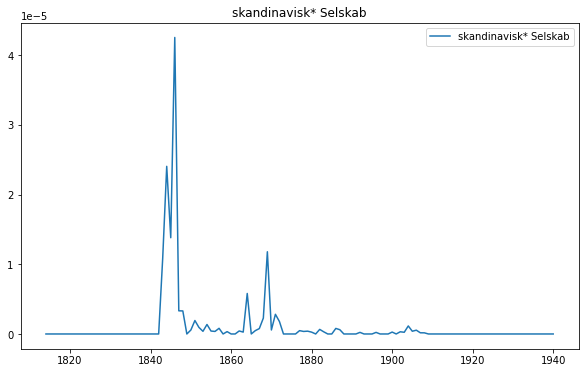

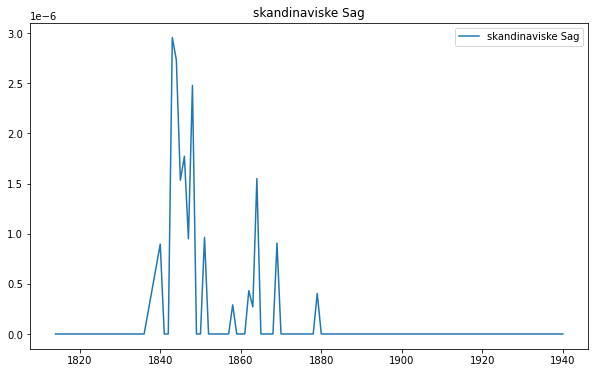

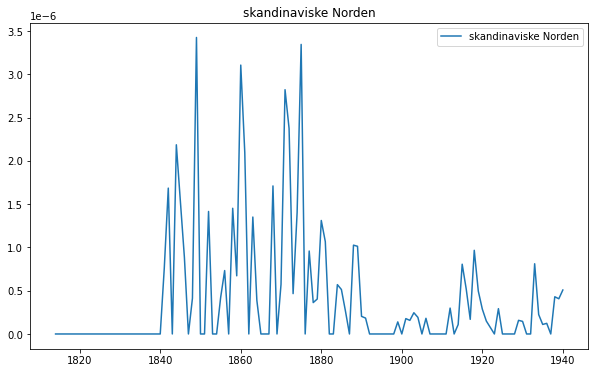

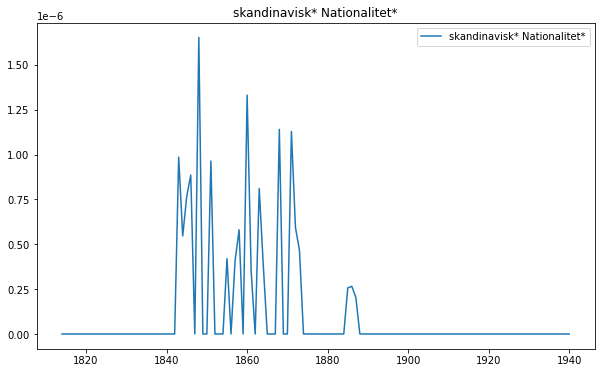

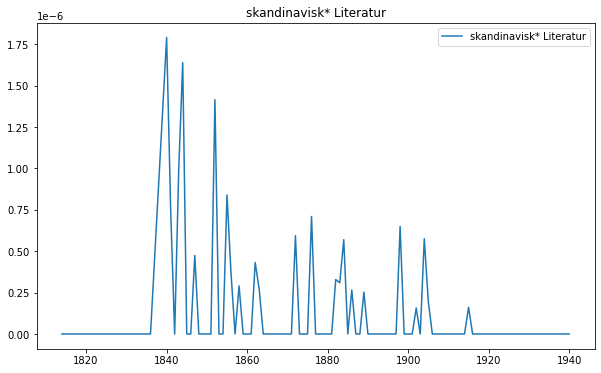

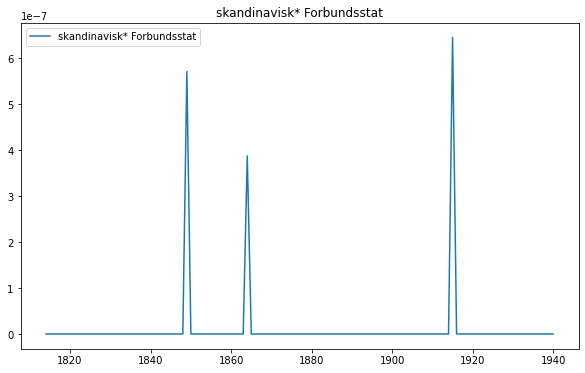

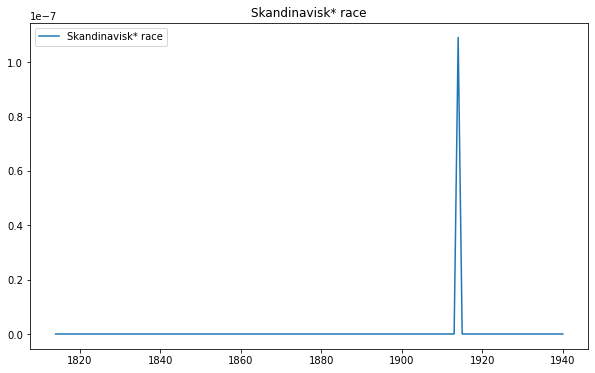

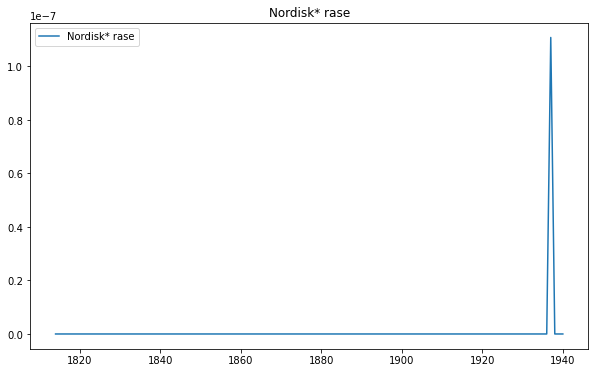

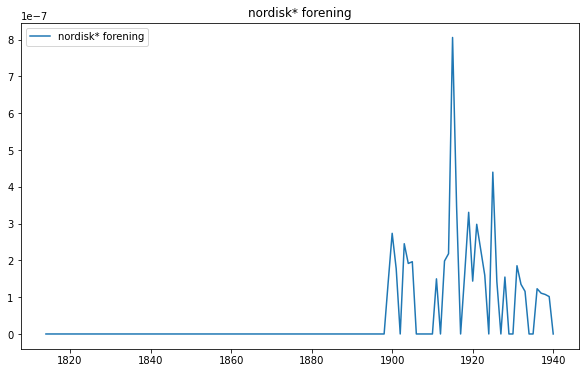

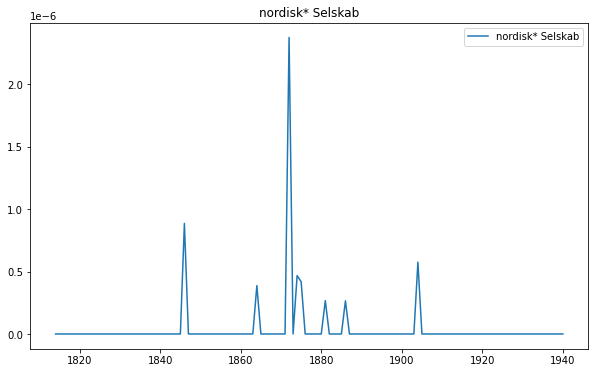

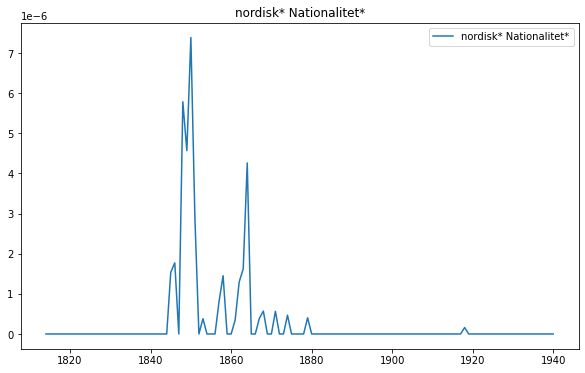

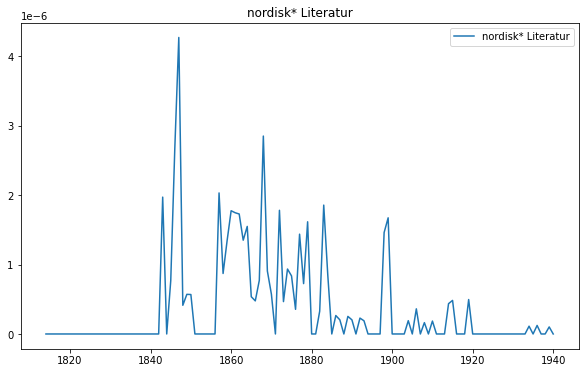

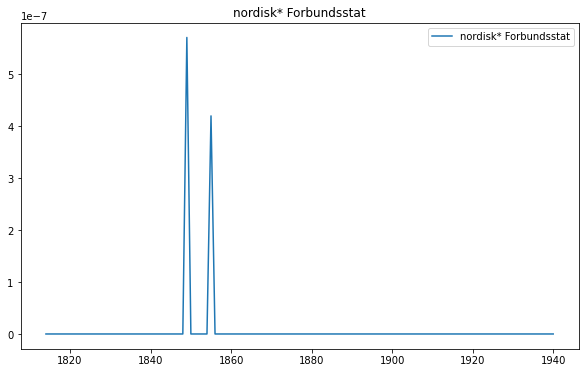

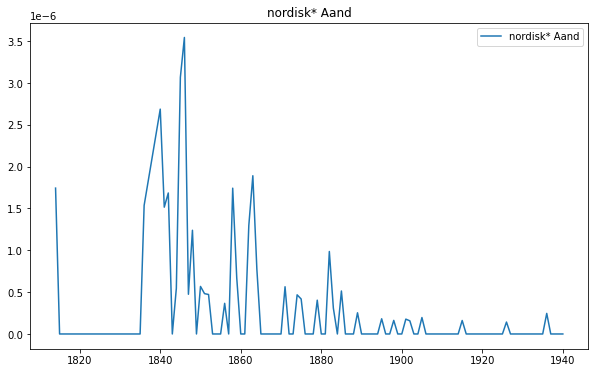

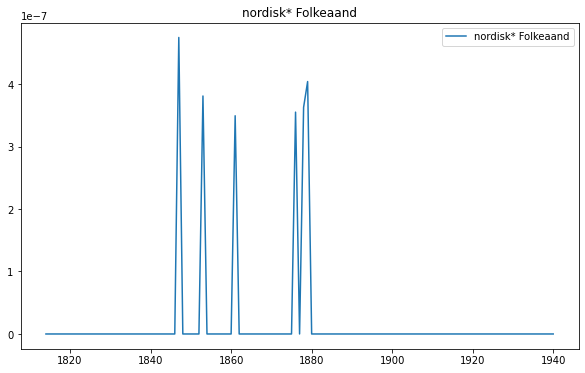

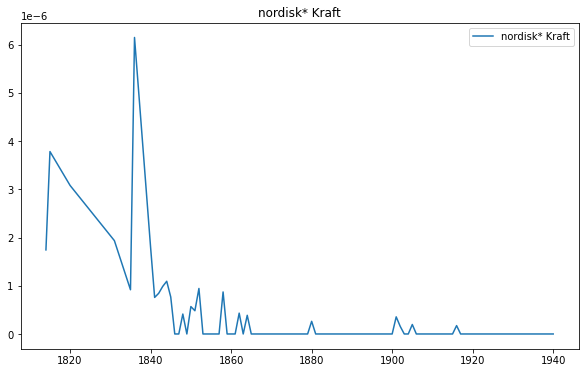

In [280]:
for x in subsetrel:
    nb.frame(subsetrel[x]).plot(title = x, figsize=(10,6));
    plt.savefig(os.path.join('grafer', secure_filename(x) + '.jpg'))

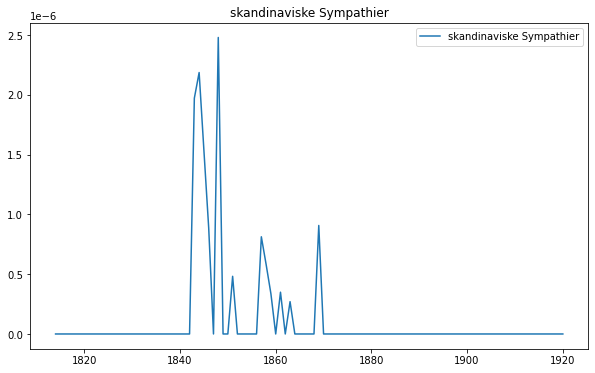

In [281]:
høyord

,ref
1790,228321
1791,333160
1792,346687
1793,379574
1794,310246
...,...
1936,8132611
1937,9020901
1938,9304057
1939,9835459


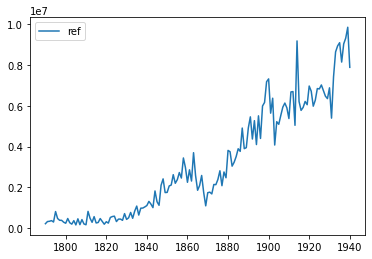

In [282]:
høyord.plot()

In [283]:
enkeltord = ['skandinavisk', 'nordisk']
def add(x, suffixes = ''):
    return [x + s for s in suffixes]
        
enkeltord = {x:[y.capitalize() for y in add(x, ['', 'e'])] for x in enkeltord}
enkeltord

{'skandinavisk': ['Skandinavisk', 'Skandinaviske'],
 'nordisk': ['Nordisk', 'Nordiske']}

In [290]:
unihoved = {z:pd.concat([nb.unigram(x, media='avis', period=(1790, 1940)) for x in enkeltord[z]], axis=1).sum(axis=1) for z in enkeltord}

In [291]:
uni = nb.frame(unihoved).transpose().fillna(0).sort_index()

In [292]:
uni.index = uni.index.astype('int64')

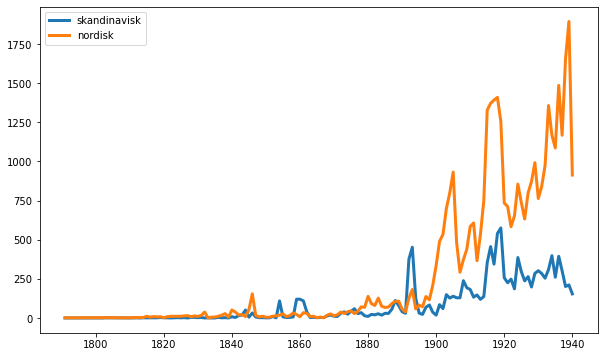

In [293]:
uni.plot(figsize=(10,6), lw=3)

In [294]:
unirel = nb.frame({x:uni[x]/høyord.ref for x in uni}).transpose().fillna(0)

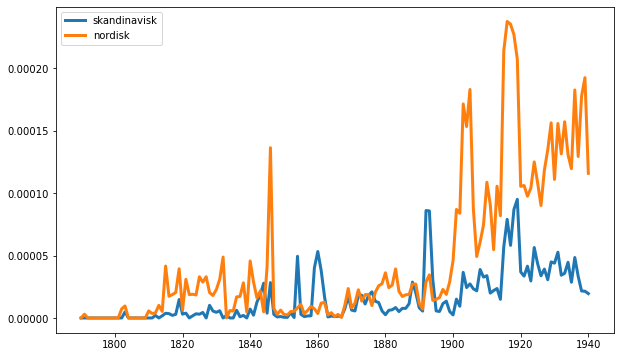

In [295]:
unirel.plot(figsize=(10,6), lw=3)

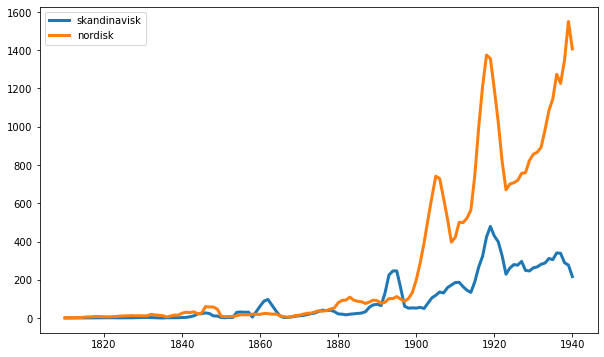

In [296]:
uni.rolling(window=4).mean().plot(figsize=(10,6), lw=3);

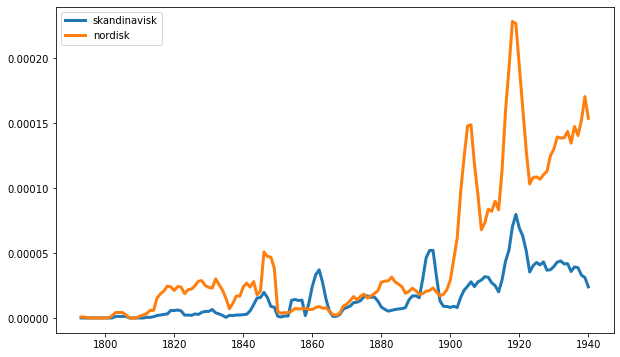

In [297]:
unirel.rolling(window=4).mean().plot(figsize=(10,6), lw=3);